In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

from joblib import Parallel

from useful_func import *


from skimage.transform import rescale, resize, downscale_local_mean
import skimage
from scipy.ndimage import binary_erosion


import tifffile as tiff
from tqdm import tqdm

sigma_480 = 198 #m2/mol
sigma_405 = 415 #m2/mol
tau_relax = 0.014

import click

#%matplotlib widget

In [18]:
file= "../data/epi_shape/video_gel_light2.tiff"
timing = np.load("../data/epi_shape/video_timing_gel_light2.npy")

name = os.path.split(file)[1][:-5]
#file = click.prompt("Enter the file or folder path", type=str, default=file_default)

if os.path.isfile(file):
    video = tiff.imread(file)
    
elif os.path.isdir(file):
    video = []
    for im in tqdm(glob.glob(file + "/*.tiff")):
        video.append(tiff.imread(im))
    video = np.array(video)
    
else:
    print('wrong path')
    
video.shape
ratio = 0.0009924973725647765

In [4]:
framerate = len(timing)/(timing[-1]-timing[0])
framerate

3.02592364259727

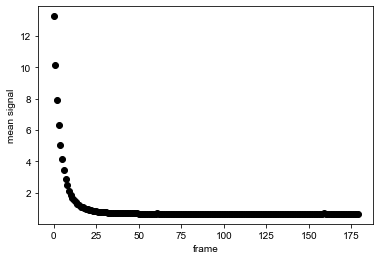

<Figure size 432x288 with 0 Axes>

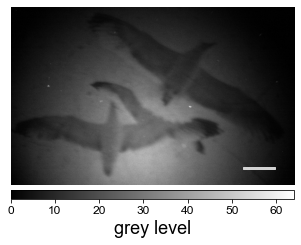

In [19]:
plt.xlabel('frame')
plt.ylabel('mean signal')
plt.plot(np.mean(video[0:], axis = (1,2)), "ko")
plt.figure()

slices = np.mean(video, axis = (1,2))
frames = video[0:1]
frame_ref = np.mean(frames, axis =0)


p.set_figure()
plt.axis("off")
image = plt.imshow(video[0][::-1], cmap = "gray")
L, H = video[0].shape
scale = 660//6
rec = matplotlib.patches.Rectangle((H-H//5.5, L-L//10), scale, L//100, color = "lightgrey")
#rec = matplotlib.patches.Rectangle((H, L), scale*10, L, color = "red")

ax = plt.gca()
ax.add_patch(rec)
divider = make_axes_locatable(plt.gca())
axdef = divider.append_axes("bottom", "5%", pad="3%")
cbar = plt.colorbar(image, cax=axdef, orientation = "horizontal")
ax = plt.gca()
plt.xlabel("grey level", size=p.fontsize)

ax.tick_params(labelsize=p.fonttick)


plt.savefig(p.save_folder + "/epi_intensity" + p.extension)

plt.savefig("../images/"+ name + "_image.pdf")

In [20]:
scale*ratio

0.10917471098212542

In [7]:
D = click.prompt("smoothing & downscaling factor to accelerate computations", type=int, default=5)
D_image = downscale_local_mean(frame_ref, (D,D))

#downscaling 
video_downscaled = []
for i in range(0, video.shape[0]):
    video_downscaled.append(downscale_local_mean(video[i], (D, D)))
video_downscaled = np.array(video_downscaled)
init_shape = np.copy(video_downscaled.shape)
L, H = init_shape[1:]


smoothing & downscaling factor to accelerate computations [5]:

  1


skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


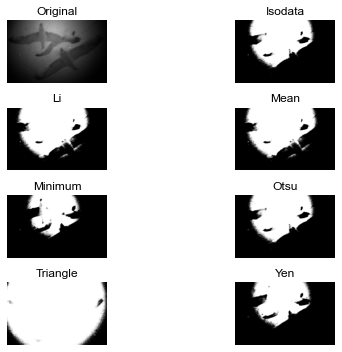

In [8]:
u = skimage.filters.try_all_threshold(D_image)


copy the name of the thresholding method that suits you. If none suits, enter None [skimage.filters.thresholding.threshold_li]:

  none


none


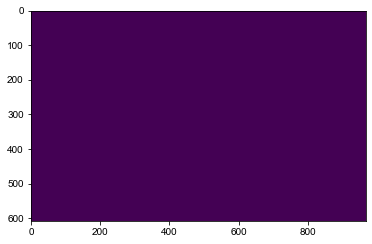

In [9]:
threshold_method = threshold_convert(click.prompt("copy the name of the thresholding method that suits you. If none suits, enter None", type = str, default="skimage.filters.thresholding.threshold_li"))

video = np.array(video)
#timing = np.linspace(0, len(video)-1, len(video))/framerate #generate time array from framerate
timing -= timing[0]
threshold = threshold_method(D_image)

mask = D_image>= 0# threshold

plt.imshow(mask)



Text(0, 0.5, 'fluorescence')

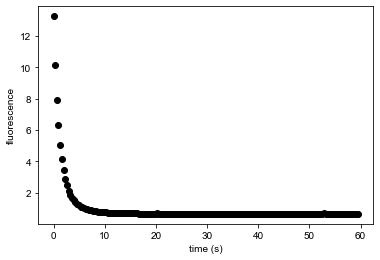

In [10]:
video_2D = np.copy(video_downscaled)
video_downscaled = video_downscaled.reshape(video_downscaled.shape[0], -1)

to_evaluate = video_downscaled[:,mask.flatten()]

plt.plot(timing, np.mean(to_evaluate, axis = 1), 'ok')
plt.xlabel('time (s)')
plt.ylabel('fluorescence')

First useful frame [0]:

  0


Last useful frame [0]:

  100


[12.10255672  1.21505865  1.00964359]


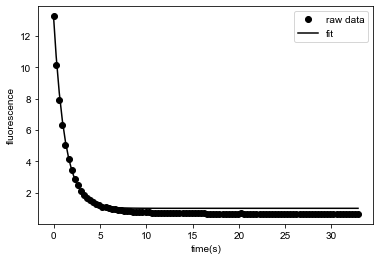

In [11]:
start = click.prompt("First useful frame", type=int, default=0)
stop = click.prompt("Last useful frame", type=int, default=0)


#fit on the mean value before performing the fit on each pixel
params = simple_tau(np.mean(to_evaluate[start:stop], axis = 1), timing[start:stop], sample_rate = framerate)
print(params)
time = timing[start:stop]
time -= time[0]
plt.plot(time, np.mean(to_evaluate[start:stop], axis = 1), "ok", label = "raw data")
plt.plot(time, exp_decay(params, time), "k", label = "fit")
plt.xlabel('time(s)')
plt.ylabel("fluorescence")
plt.legend()
plt.savefig(p.save_folder + name +  "_mean_decay_fit_D2.png")

In [12]:
sat = np.sum(to_evaluate[0]==255)/len(to_evaluate[0].flatten())*100
print("percent of saturated pixels in the mask: ", sat)
if sat > 2:
    print("WARNING, more than 2% of the pixels are saturated on the first frame, try acquiring the movie with shorter exposure/smaller gain.")

percent of saturated pixels in the mask:  0.0


In [13]:
#parallel fit on each pixel of the mask
tau_lists = Parallel(n_jobs = -1 )(parallel_tau(to_evaluate[start:stop,i], timing[start:stop], sample_rate = framerate) for i in tqdm(range(to_evaluate.shape[1])))


100%|████████████████████████████████████████████████████████████████████████| 588544/588544 [06:32<00:00, 1497.68it/s]


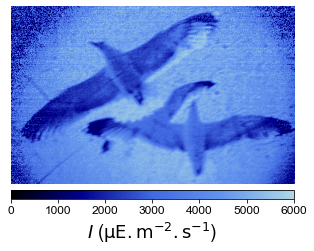

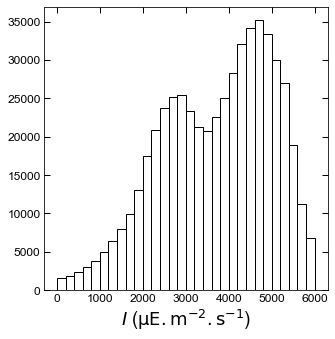

In [15]:
tau_480 = np.array(tau_lists)
tau_480_map = np.zeros(mask.shape)
tau_480_map[mask] = tau_480

np.save("../images/tau_480_map_gel_light.npy", tau_480_map)


I_480 = 1e6*(1/tau_480 - tau_relax)/sigma_480
I_480_map = np.zeros(mask.shape)
I_480_map[mask] = I_480

np.save("../images/I_480_map_gel_light.npy", I_480_map)

plt.rcParams['image.cmap'] = 'viridis'

p.extension = ".pdf"
 
I, dis, fig = plot_map(I_480, I_480_map[::-1, ::-1], name + "_I_480_map_B" + p.extension, limits = (0, 6000), scalebar=False)



np.save("../images/video_2D_gel_light.npy", video_2D[start:stop])
np.save("../images/framerate_gel_light.npy", framerate)


In [6]:
I_480_map = np.load("../images/I_480_map_gel_light.npy")
I, dis, fig = plot_map(I_480, I_480_map[::-1, ::-1], name + "_I_480_map_B_bis" + p.extension, limits = (0, 6000))


NameError: name 'I_480' is not defined

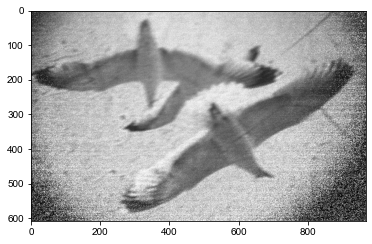

In [25]:
plt.imshow(I_480_map, cmap = 'gray')

In [19]:
plt.imshow(I==I.max())

NameError: name 'I' is not defined

1.681325760667305
(160, 608, 968)
tau 0.5367196173612642
1.0101454585234917
(121, 608, 968)
tau 1.0819906804016302
1.681325760667305
(160, 608, 968)
tau 0.7300091377368672
1.0101454585234917
(121, 608, 968)
tau 1.4277058808691763


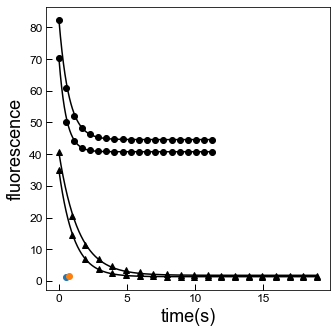

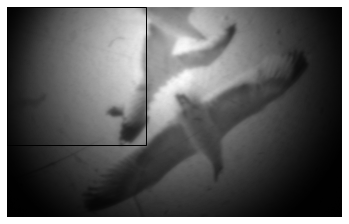

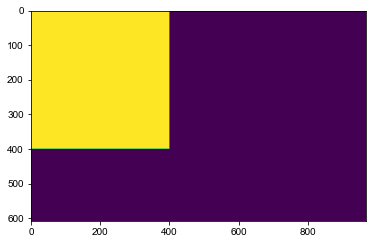

<Figure size 432x288 with 0 Axes>

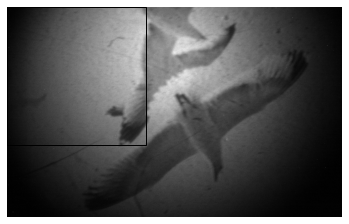

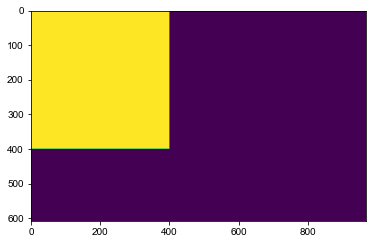

<Figure size 432x288 with 0 Axes>

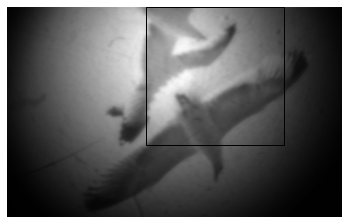

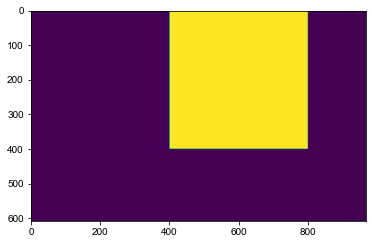

<Figure size 432x288 with 0 Axes>

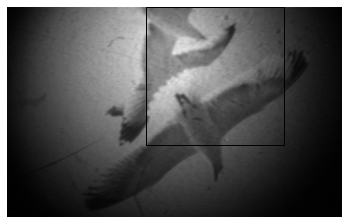

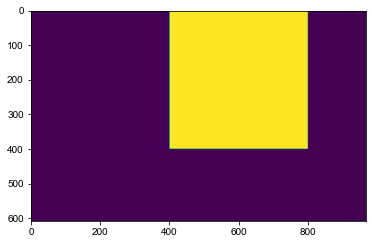

<Figure size 432x288 with 0 Axes>

In [17]:
f0 = p.set_figure("%d", "%d")
ax0 = plt.gca()

plt.xlabel('time(s)')
plt.ylabel("fluorescence")
quanta = 400
for ii in range(H//quanta):
    for jj in range(L//quanta):
        tau = []
        for num, fname in enumerate(["mouette_liq4", "mouette_gel6"]):#["timing_full_liq", "timing_full_gel"]): #["mouette_liq_fort", "mouette_gel_fort"]

            file= "../data/epi_shape/video_%s.tiff"%fname
            timing = np.load("../data/epi_shape/video_timing_%s.npy"%fname)

            framerate = len(timing)/(timing[-1]-timing[0])
            print(framerate)

            name = os.path.split(file)[1][:-5]
            #file = click.prompt("Enter the file or folder path", type=str, default=file_default)

            if os.path.isfile(file):
                video = tiff.imread(file)

            elif os.path.isdir(file):
                video = []
                for im in tqdm(glob.glob(file + "/*.tiff")):
                    video.append(tiff.imread(im))
                video = np.array(video)

            else:
                print('wrong path')


            print(video.shape)
            slices = np.mean(video, axis = (1,2))
            frames = video[:1]
            frame_ref = np.mean(frames, axis =0)
            D = 1#click.prompt("smoothing & downscaling factor to accelerate computations", type=int, default=5)
            D_image = downscale_local_mean(frame_ref, (D,D))

            plt.figure()


            plt.imshow(frame_ref, cmap = 'gray')
            plt.axis("off")
            #a, b, c, d = 300, 200, 100, 100
            #a, b, c, d = 330, 240, 10, 10
            a, b, c, d = quanta*ii, quanta*jj, quanta, quanta


            rec = matplotlib.patches.Rectangle((a, b), c, d, color = "k", fill = False)
            #rec = matplotlib.patches.Rectangle((H, L), scale*10, L, color = "red")

            ax = plt.gca()
            ax.add_patch(rec)
            D=1
            #downscaling 
            video_downscaled = []
            for i in range(0, video.shape[0]):
                video_downscaled.append(downscale_local_mean(video[i], (D, D)))
            video_downscaled = np.array(video_downscaled)
            init_shape = np.copy(video_downscaled.shape)
            L, H = init_shape[1:]


            video = np.array(video)
            #timing = np.linspace(0, len(video)-1, len(video))/framerate #generate time array from framerate
            timing -= timing[0]

            mask = np.zeros(video[0].shape).astype(bool)
            mask[b:b+d, a:a+c] = 1
            #mask[:] = 1
            plt.figure()
            plt.imshow(mask)

            video_2D = np.copy(video_downscaled)
            video_downscaled = video_downscaled.reshape(video_downscaled.shape[0], -1)

            to_evaluate = video_downscaled[:,mask.flatten()]

            start = 0
            stop = 20


            time = timing[start:stop]
            time -= time[0]

            y = np.mean(to_evaluate[start:stop], axis = 1)
            #y /= y[0]

            #fit on the mean value before performing the fit on each pixel
            params = simple_tau(y, time, sample_rate = framerate)
            print("tau", params[1])
            plt.figure()
            tau.append(params[1])
            ax0.plot(time, y, ["ok", "^k"][num], label = "raw data")
            x2 = np.linspace(time.min(), time.max(), 1024)
            ax0.plot(x2, exp_decay(params, x2), "k", label = "fit")
        ax0.scatter(tau[0], tau[1])

    #plt.legend()
    plt.savefig(p.save_folder + name +  "_mean_decay_fit_D2.png")


179 19
FR: 1
7.190480892108479
FR: 1
5.880721452209095
FR: 1
5.757017771567816
FR: 1
5.251125108785324
FR: 1
5.089887786360076
FR: 1
4.856668239031577
FR: 1
5.692794032390718
FR: 1
5.924264110309732
FR: 1
4.501485931223648
FR: 1
4.567162680815981
FR: 1
4.158681951438733
FR: 1
3.996048459082194
FR: 1
4.024262241287164
FR: 1
3.8789650743817803
FR: 1
4.187678506422186
FR: 1
3.9084641305598815
FR: 1
4.4551955043895095
FR: 1
4.187669124567442
FR: 1
4.446206839848855
FR: 1
5.232489591743461
FR: 1
5.178994182774689
FR: 1
6.41192678838224
FR: 1
5.515218936740963
FR: 1
2.083776247725176
179 19
FR: 1
5.168992409815911
FR: 1
4.476647729005466
FR: 1
4.296934995426389
FR: 1
3.9000940220558946
FR: 1
3.9420769210825406
FR: 1
3.6754386854179315
FR: 1
5.125151886843626
FR: 1
4.826943615519363
FR: 1
4.446264049992873
FR: 1
4.311558783438355
FR: 1
3.682967236118516
FR: 1
3.3424949430443367
FR: 1
3.5720875257884477
FR: 1
3.271384314735461
FR: 1
3.519351341789921
FR: 1
3.3045730805450426
FR: 1
3.5387099712

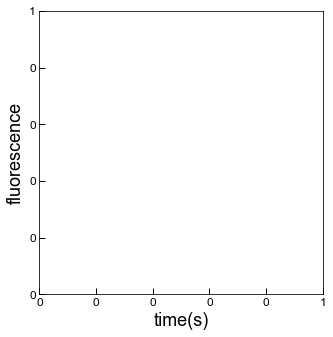

In [33]:
f0 = p.set_figure("%d", "%d")
ax0 = plt.gca()

plt.xlabel('time(s)')
plt.ylabel("fluorescence")
quanta = 50
taus = []
for ii in range(0, H//quanta):
    print(i, H//quanta)
    for jj in range(0, L//quanta):
        taus.append([])
        for num, fname in enumerate(["gel_light2", "liq_light"]):#["liq_full", "gel_full"]):#["timing_full_liq", "timing_full_gel"]): #["mouette_liq_fort", "mouette_gel_fort"]

            file= "../data/epi_shape/video_%s.tiff"%fname
            timing = np.load("../data/epi_shape/video_timing_%s.npy"%fname)

            framerate = 1#len(timing)/(timing[-1]-timing[0])
            print("FR:", framerate)

            name = os.path.split(file)[1][:-5]
            #file = click.prompt("Enter the file or folder path", type=str, default=file_default)

            if os.path.isfile(file):
                video = tiff.imread(file)

            elif os.path.isdir(file):
                video = []
                for im in tqdm(glob.glob(file + "/*.tiff")):
                    video.append(tiff.imread(im))
                video = np.array(video)

            else:
                print('wrong path')


            slices = np.mean(video, axis = (1,2))
            frames = video[:1]
            frame_ref = np.mean(frames, axis =0)
            D = 1#click.prompt("smoothing & downscaling factor to accelerate computations", type=int, default=5)
            D_image = downscale_local_mean(frame_ref, (D,D))


            #a, b, c, d = 300, 200, 100, 100
            #a, b, c, d = 330, 240, 10, 10
            a, b, c, d = quanta*ii, quanta*jj, quanta, quanta

            D=1
            #downscaling 
            video_downscaled = []
            for i in range(0, video.shape[0]):
                video_downscaled.append(downscale_local_mean(video[i], (D, D)))
            video_downscaled = np.array(video_downscaled)
            init_shape = np.copy(video_downscaled.shape)
            L, H = init_shape[1:]


            video = np.array(video)
            #timing = np.linspace(0, len(video)-1, len(video))/framerate #generate time array from framerate
            timing -= timing[0]

            mask = np.zeros(video[0].shape).astype(bool)
            mask[b:b+d, a:a+c] = 1
            #mask[:] = 1

            video_2D = np.copy(video_downscaled)
            video_downscaled = video_downscaled.reshape(video_downscaled.shape[0], -1)

            to_evaluate = video_downscaled[:,mask.flatten()]

            start = 0
            stop = 20


            time = timing[start:stop]
            time -= time[0]

            y = np.mean(to_evaluate[start:stop], axis = 1)
            #y /= y[0]

            #fit on the mean value before performing the fit on each pixel
            params = simple_tau(y, time, sample_rate = framerate)
            taus[-1].append(params[1])
            print(params[1])
            #ax0.plot(time, y, ["ok", "^k"][num], label = "raw data")
            x2 = np.linspace(time.min(), time.max(), 1024)
            #ax0.plot(x2, exp_decay(params, x2), "k", label = "fit")

    #plt.legend()
    plt.savefig(p.save_folder + name +  "_mean_decay_fit_D2.png")


(-100.0, 100.0)

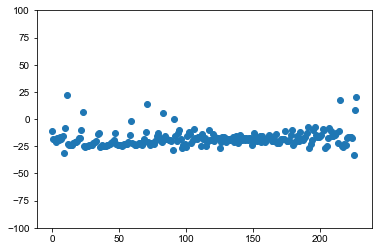

In [18]:
taus = np.array(taus)
plt.plot((taus[:, 0]-taus[:, 1])/taus[:,0]*100, 'o')
plt.ylim(-100, 100)

Text(0, 0.5, '$\\tau_{gel}$')

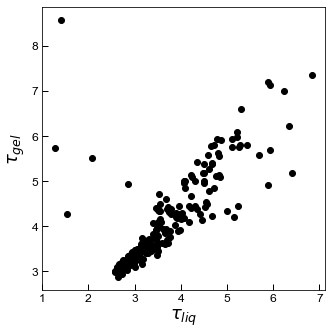

In [38]:
taus = np.array(taus)
fig = p.set_figure("%d", "%d")
plt.plot(taus[:, 1], taus[:, 0], 'ok')

plt.xlabel(r"$\tau_{liq}$")
plt.ylabel(r"$\tau_{gel}$")

In [20]:
x = taus[:, 0]-taus[:, 1]

In [21]:
taus

array([[2.79855719, 3.10651953],
       [2.18722648, 2.59025232],
       [1.67523943, 1.99706017],
       [1.39641024, 1.69037482],
       [1.24718285, 1.46690971],
       [1.24113113, 1.47591297],
       [1.14633642, 1.33663777],
       [1.15268684, 1.36662352],
       [1.26088758, 1.45558821],
       [1.38055342, 1.80763067],
       [1.28477421, 1.39322867],
       [0.96130305, 0.74503898],
       [1.7300527 , 2.12637471],
       [1.28861806, 1.59623171],
       [1.04681758, 1.29485781],
       [0.94224781, 1.16698141],
       [0.89293019, 1.08575804],
       [0.95399017, 1.15321788],
       [0.87484718, 1.05836242],
       [0.87960927, 1.05874979],
       [0.91907466, 1.08167731],
       [1.02395249, 1.20027506],
       [1.0646724 , 1.17322383],
       [1.26083956, 1.18307356],
       [1.14745289, 1.43443911],
       [0.97047083, 1.21642993],
       [0.8818763 , 1.09652849],
       [0.84422604, 1.05657783],
       [0.82467451, 1.02445287],
       [0.83475282, 1.03346038],
       [0.

120 9
89 9
89 9
89 9
89 9


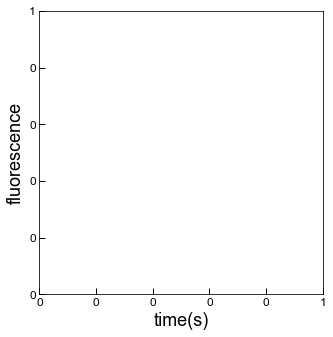

In [22]:
f0 = p.set_figure("%d", "%d")
ax0 = plt.gca()

plt.xlabel('time(s)')
plt.ylabel("fluorescence")
quanta = 100
taus = []
for ii in range(2, H//quanta-2):
    print(i, H//quanta)
    for jj in range(2, L//quanta-2):
        taus.append([])
        for num, fname in enumerate(["liq_full", "gel_full"]):#["mouette_liq_fort", "mouette_gel_fort"]):#["liq_full", "gel_full"]):#["timing_full_liq", "timing_full_gel"]): #["mouette_liq_fort", "mouette_gel_fort"]

            file= "../data/epi_shape/video_%s.tiff"%fname
            timing = np.load("../data/epi_shape/video_timing_%s.npy"%fname)

            framerate = len(timing)/(timing[-1]-timing[0])

            name = os.path.split(file)[1][:-5]
            #file = click.prompt("Enter the file or folder path", type=str, default=file_default)

            if os.path.isfile(file):
                video = tiff.imread(file)

            elif os.path.isdir(file):
                video = []
                for im in tqdm(glob.glob(file + "/*.tiff")):
                    video.append(tiff.imread(im))
                video = np.array(video)

            else:
                print('wrong path')


            slices = np.mean(video, axis = (1,2))
            frames = video[:1]
            frame_ref = np.mean(frames, axis =0)
            D = 1#click.prompt("smoothing & downscaling factor to accelerate computations", type=int, default=5)
            D_image = downscale_local_mean(frame_ref, (D,D))


            #a, b, c, d = 300, 200, 100, 100
            #a, b, c, d = 330, 240, 10, 10
            a, b, c, d = quanta*ii, quanta*jj, quanta, quanta

            D=1
            #downscaling 
            video_downscaled = []
            for i in range(0, video.shape[0]):
                video_downscaled.append(downscale_local_mean(video[i], (D, D)))
            video_downscaled = np.array(video_downscaled)
            init_shape = np.copy(video_downscaled.shape)
            L, H = init_shape[1:]


            video = np.array(video)
            #timing = np.linspace(0, len(video)-1, len(video))/framerate #generate time array from framerate
            timing -= timing[0]

            mask = np.zeros(video[0].shape).astype(bool)
            mask[b:b+d, a:a+c] = 1
            #mask[:] = 1

            video_2D = np.copy(video_downscaled)
            video_downscaled = video_downscaled.reshape(video_downscaled.shape[0], -1)

            to_evaluate = video_downscaled[:,mask.flatten()]

            start = 0
            stop = 300


            time = timing[start:stop]
            time -= time[0]

            y = np.mean(to_evaluate[start:stop], axis = 1)
            #y /= y[0]

            #fit on the mean value before performing the fit on each pixel
            params = simple_tau(y, time, sample_rate = framerate)
            taus[-1].append(params[1])
            
            #ax0.plot(time, y, ["ok", "^k"][num], label = "raw data")
            x2 = np.linspace(time.min(), time.max(), 1024)
            #ax0.plot(x2, exp_decay(params, x2), "k", label = "fit")

    #plt.legend()
    plt.savefig(p.save_folder + name +  "_mean_decay_fit_D2.png")


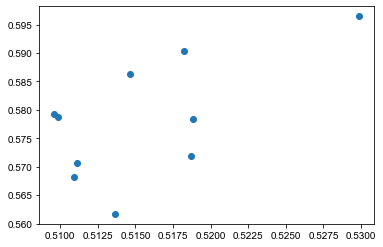

In [23]:
taus = np.array(taus)
plt.plot(taus[:, 0], taus[:, 1], 'o')
